## Zanini, Berghuis et al. 2019
### Pancreas datasets
### Fig 3 and related supplementary figures

In [1]:
# import third party packages:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from umap import UMAP

import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.lines as mlines
%matplotlib notebook

import matplotlib.pyplot as plt
import seaborn as sns

# Make sure you can import northstar by adding its parent folder to your PYTHONPATH aka sys.path
sys.path.insert(0, os.path.abspath('..')+'/northstar/build/lib') # Fabio's laptop
import northstar

# Make sure you can import the modules in the 'modules' folder by adding it to your PYTHONPATH aka sys.path
sys.path.append(os.path.abspath('.')+'/modules')
import northstar_analysis as noa
import northstar_sankey as nosa
import northstar_dotplot as ndot
import get_timestamp as time

## Prepare new dataset
### 11 pancreatic tumors and 1 healthy pancreas


In [2]:
fn_counts = 'data/PancreasTumors/CuratedTumorCountTable.csv'
fn_metadata = 'data/PancreasTumors/CuratedTumorMetaData.csv'
counts_all = pd.read_csv(fn_counts, sep=',', index_col=0).astype(np.float32)
meta_all = pd.read_csv(fn_metadata, sep=',', index_col=0)

## Count number of cells per tumor

<IPython.core.display.Javascript object>


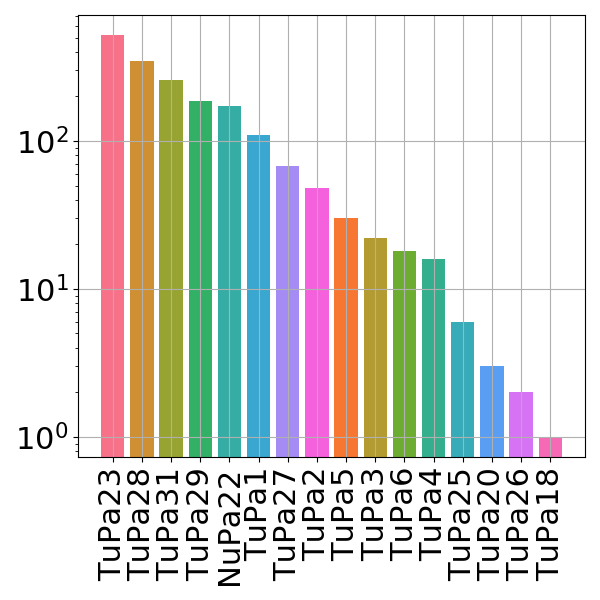

In [3]:
fig, ax = plt.subplots(figsize=(6, 6))
y = meta_all['Tumor'].value_counts()
n = len(y)
x = np.arange(n)
colors = sns.color_palette('husl', n_colors=n)
colors = colors[::2] + colors[1::2]
for i in range(n):
    ax.bar([i], [y.iloc[i]], color=colors[i])
ax.set_xticks(x)
ax.set_xticklabels(y.index, rotation=90)
ax.set_yscale('log')
ax.grid(True)
fig.tight_layout()

In [4]:
# Exclude patients with < 10 cells and normal
ind = ~meta_all['Tumor'].isin(['NuPa22', 'TuPa20', 'TuPa25', 'TuPa26', 'TuPa18'])
meta = meta_all.loc[ind].copy()
counts = counts_all.loc[:, ind]

## Classify cell using atlases
We reannotated the atlas to increase resolution for rare populations (stellate, epsilon)

In [5]:
# Change names to forget atlas, else they are too long
def sanitize_cell_type(x):
    if 't_cell' in x:
        out = 'T cell'
    elif ('stellate' in x) and ('Enge' not in x):
        out = ' '.join(x.split('_')[-2:])
    else:
        out = x.split('_')[-1]
    return out

In [6]:
model = northstar.Averages(
    atlas=[
        {'atlas_name': 'Baron_2016',
         'cell_types': [
        'acinar', 'beta', 'delta', 'activated_stellate',
        'ductal', 'alpha',
        'epsilon', 'gamma', 'endothelial', 'quiescent_stellate',
        'macrophage',
        'schwann', 'mast',
        't_cell'],
        },
        {'atlas_name': 'Zanini_2018',
         'cell_types': [
             'B cell',
             #'T cell',
             'NK cell',
             'classical monocyte', 'nonclassical monocyte',
             'plasmablast',
         ],
        },
    ],
    n_pcs=35,
    n_cells_per_type=20,
    n_features_per_cell_type=40,
    n_features_overdispersed=400,
    n_neighbors=25,
    resolution_parameter=0.02,
)
model.fit(counts)
meta['cellType'] = [sanitize_cell_type(x) for x in model.membership]
model.estimate_closest_atlas_cell_type()

(35, 5) (35, 19)


21    Baron_2016_acinar
23    Baron_2016_acinar
19    Baron_2016_acinar
20    Baron_2016_acinar
22    Baron_2016_acinar
dtype: object

'correlation'

### Extract principal components from northstar and calculate tSNE

In [ ]:
cte = list(map(sanitize_cell_type, model.pca_data['cell_type']))
ctypes = np.array(cte)
ctypes[nae:] = meta['cellType'].values
nae = model.pca_data['n_atlas']
d = np.ones((len(cte), len(cte)))
for i, nis in enumerate(model.neighbors):
    for ni in nis:
        d[i, ni] = 0

vs = TSNE(perplexity=30, metric='precomputed').fit_transform(d)

In [ ]:
# Export data for figure
df = pd.DataFrame(vs, columns=['tsne1', 'tsne2'])
df['cellType'] = ctypes.copy()
df['cellID'] = ''
df['cellID'].iloc[nae:] = counts.columns.values
#df.to_csv('data_for_figures/pancreas_cell_type_tsne.tsv', sep='\t')

### Plot

<IPython.core.display.Javascript object>


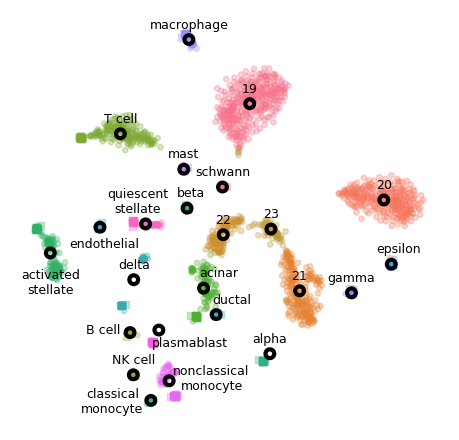

In [215]:
# Load data
df = pd.read_csv('data_for_figures/pancreas_cell_type_tsne.tsv', sep='\t')
ctypes = df['cellType'].values
nae = (df['cellID'].astype(str) == 'nan').sum()
meta['cellType'] = ctypes[nae:]
vs = df[['tsne1', 'tsne2']].values

fig, ax = plt.subplots(figsize=(4.6, 4.4))

# Set colors
ctypesu = np.unique(ctypes)
lctu = len(ctypesu)
colorsu = sns.color_palette('husl', n_colors=lctu)
cmap = dict(zip(ctypesu, colorsu))
colors = [cmap[x] for x in ctypes]

# Plot atlas cells as squares, new cells as dots
ax.scatter(vs[:nae, 0], vs[:nae,1], s=25, marker='s', c=colors[:nae], alpha=0.3)
ax.scatter(vs[nae:, 0], vs[nae:,1], s=15, marker='o', c=colors[nae:], alpha=0.3)

for ct in ctypesu:
    ind = ctypes == ct
    x, y = vs[ind].mean(axis=0)
    xt = x
    yt = y + 2 * vs.max() / 50.
    if ct == 'classical monocyte':
        xt -= 10 * vs.max() / 50.
        yt -= 6 * vs.max() / 50.
    elif ct == 'quiescent stellate':
        xt -= 2 * vs.max() / 50.
        yt -= 0 * vs.max() / 50.
    elif ct == 'activated stellate':
        xt -= 0 * vs.max() / 50.
        yt -= 13 * vs.max() / 50.
    elif ct == 'nonclassical monocyte':
        xt += 11 * vs.max() / 50.
        yt -= 5 * vs.max() / 50.
    elif ct == 'B cell':
        xt -= 7 * vs.max() / 50.
        yt -= 3 * vs.max() / 50.
    elif ct == 'plasmablast':
        xt += 8 * vs.max() / 50.
        yt -= 7 * vs.max() / 50.
    elif ct == 'beta':
        xt += 1 * vs.max() / 50.
    elif ct == 'epsilon':
        xt += 2 * vs.max() / 50.
    elif ct == 'acinar':
        xt += 4 * vs.max() / 50.
    elif ct == 'ductal':
        xt += 4 * vs.max() / 50.
    elif ct == 'endothelial':
        yt -= 8 * vs.max() / 50.
        xt += 1 * vs.max() / 50.
    if len(ct) > 10:
        ct = ct.replace(' ', '\n')
    ax.text(xt, yt, ct, ha='center', va='bottom', fontsize=9)
    ax.scatter([x], [y], s=40, edgecolor='k', lw=3, facecolor='none')
    
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()
fig.tight_layout()

fig.savefig('figures/Fig3A.svg')
fig.savefig('figures/Fig3A.png', dpi=600)

<IPython.core.display.Javascript object>


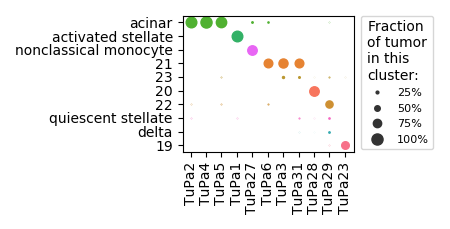

In [214]:
# Plot distribution of cells across cell types
fig2, ax1 = plt.subplots(figsize=(4.5, 2.3))
df = meta[['Tumor', 'cellType']].copy()
df['c'] = 1
df = df.groupby(['Tumor', 'cellType']).sum()['c'].unstack().fillna(0).astype(int)
dfn = 1.0 * (df.T / df.T.sum(axis=0)).T

tumor_order = ['TuPa'+str(x) for x in [2, 4, 5, 1, 27, 6, 3, 31, 28, 29, 23]]
dfn_sort = dfn.loc[tumor_order]
cell_type_order = [
    'acinar', 'activated stellate', 'nonclassical monocyte',
    '21', '23', '20', '22', 'quiescent stellate', 'delta', '19']
dfn_sort = dfn_sort.loc[:, cell_type_order]


#sns.heatmap(dfn_sort, ax=ax1, xticklabels=True, yticklabels=True, cbar=False, cmap='magma')
def size_fun(fr):
    return (8 * fr)**2
    
for i in range(dfn_sort.shape[0]):
    for j in range(dfn_sort.shape[1]):
        fr = dfn_sort.values[i, j]
        r = size_fun(fr)
        color = cmap[dfn_sort.columns[j]]
        ax1.scatter([i + 0.5], [j + 0.5], color=color, s=[r])
ax1.set_yticks(0.5 + np.arange(dfn_sort.shape[1]))
ax1.set_xticks(0.5 + np.arange(dfn_sort.shape[0]))
ax1.set_yticklabels(dfn_sort.columns)
ax1.set_xticklabels(dfn_sort.index, rotation=90)

for tk in ax1.get_xticklabels():
    tk.set_fontsize(10)
for tk in ax1.get_yticklabels():
    tk.set_fontsize(10)
ax1.set_ylim(dfn_sort.shape[1], 0)
ax1.set_xlabel('')
ax1.set_ylabel('')

handles = []
labels = []
for fr in [0.25, 0.5, 0.75, 1.0]:
    h = mlines.Line2D(
        [], [], color=[0.2] * 3, marker='o', lw=0,
        markersize=np.sqrt(size_fun(fr)),
        )
    handles.append(h)
    labels.append(str(int(100 * fr))+'%')
ax1.legend(
    handles, labels,
    loc='upper left',
    title='Fraction\nof tumor\nin this\ncluster:',
    fontsize=8,
    ncol=1,
    bbox_to_anchor=(1.01, 1.04),
    bbox_transform=ax1.transAxes,
)

fig2.tight_layout()
fig2.savefig('figures/Fig3B.svg')
fig2.savefig('figures/Fig3B.png', dpi=600)

## Find markers for each new cluster

In [11]:
from scipy.stats import ks_2samp

ct_new = meta['cellType'].unique()
ct_new = [str(x) for x in range(50) if str(x) in ct_new]
markers = {}
for ct in ct_new:
    print('DEGs for cluster:', ct)
    ind = meta['cellType'] == ct
    cp = counts.loc[:, ind]
    cn = counts.loc[:, ~ind]
    indg = ((cp > 10).mean(axis=1) >= 0.3) & ((cn < 10).mean(axis=1) >= 0.6)
    genes = cp.index[indg]
    print('Candidate genes: {:}'.format(len(genes)))
    kss = []
    for ig, gene in enumerate(genes):
        cp1 = cp.loc[gene].values
        cn1 = cn.loc[gene].values
        
        res = ks_2samp(cp1, cn1)
        kss.append([res.statistic, res.pvalue])
    kss = pd.DataFrame(kss, columns=['statistic', 'pvalue'], index=genes)
    kss.sort_values(by='statistic', ascending=False, inplace=True)
    markers[ct] = kss.index[:50]
markers_top = pd.DataFrame({k: v[:10] for k, v in markers.items()})

DEGs for cluster: 19
Candidate genes: 149
DEGs for cluster: 20
Candidate genes: 3301
DEGs for cluster: 21
Candidate genes: 1428
DEGs for cluster: 22
Candidate genes: 1151
DEGs for cluster: 23
Candidate genes: 15


ValueError: arrays must all be same length

<IPython.core.display.Javascript object>


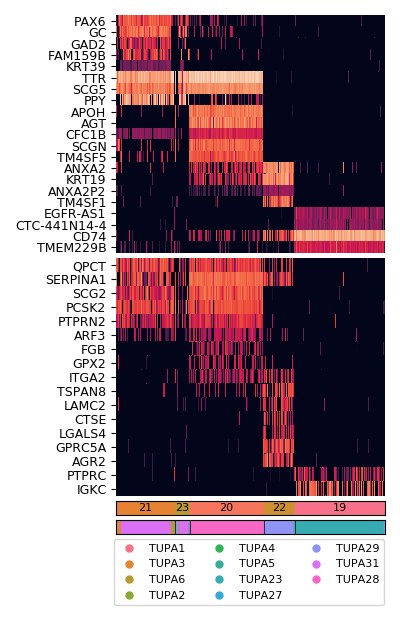

In [211]:
ctype_order = ['21', '23', '20', '22', '19']
genes1 = []
for col in ctype_order:
    for ig, gene in enumerate(markers_top[col].values):
        if ig > 4:
            continue
        if gene.startswith('RPL'):
            continue
        if 'orf' in gene:
            continue
        if gene not in genes1:
            genes1.append(gene)

genes2 = [
    'QPCT', 'SERPINA1',
    'SCG2', 'PCSK2', 'PTPRN2',
    'ARF3', 'FGB', 'GPX2',
    'ITGA2', 'TSPAN8',
    'LAMC2', 'CTSE', 'LGALS4', 'GPRC5A', 'AGR2',
    'PTPRC', 'IGKC',
    ]

genes = list(set(genes1) | set(genes2))

cov = counts.sum(axis=0)
ind = meta['cellType'].isin([str(x) for x in range(50)])
pmdata = meta.loc[ind, ['Tumor', 'cellType']]
pdata = np.log10(0.1 + (1e6 * counts.loc[genes] / cov)[pmdata.index])

# Sort new cell types
pmdata['cellTypeIdx'] = -1
for ill, ct in enumerate(ctype_order):
    pmdata.loc[pmdata['cellType'] == ct, 'cellTypeIdx'] = ill
pmdata.sort_values(['cellTypeIdx', 'Tumor'], inplace=True)
pdata = pdata[pmdata.index]

# Set colors
ctypesu = np.unique(ctypes)
lctu = len(ctypesu)
colorsu = sns.color_palette('husl', n_colors=lctu)
cmap = dict(zip(ctypesu, colorsu))
colors = [cmap[x] for x in ctypes]

fig, axs = plt.subplots(4, 1, figsize=(4, 6.2), gridspec_kw={'height_ratios': [17, 17, 1, 1]}, sharex=True)
ax, ax2, ax0, ax1 = axs

# Heatmap of the DEGs
sns.heatmap(pdata.loc[genes1], ax=ax, xticklabels=False, yticklabels=True, cbar=False)
for tk in ax.get_yticklabels():
    tk.set_fontsize(9)
ax.set_ylim(len(genes1), 0)

# Heatmap of the known markers
sns.heatmap(pdata.loc[genes2], ax=ax2, xticklabels=False, yticklabels=True, cbar=False)
for tk in ax2.get_yticklabels():
    tk.set_fontsize(9)
ax2.set_ylim(len(genes2), 0)

ctu = pmdata['cellType'].unique()
lctu = len(ctu)
iold = 0
ct = pmdata['cellType']
l = len(ct)
tum = pmdata['Tumor'].values
for i in range(1, l + 1):
    if (i == l) or (ct[i] != ct[iold]):
        r = plt.Rectangle((iold, 0), i - iold, 1, color=cmap[ct[iold]])
        ax0.add_patch(r)
        xm = 0.5 * (i + iold)
        ym = 0.5
        ax0.text(xm, ym, ct[i-1], ha='center', va='center', fontsize=8)
        iold = i
ax0.set_yticks([])

ctu = meta['Tumor'].unique()
lctu = len(ctu)
colorsu = sns.color_palette('husl', n_colors=lctu)
cmap = dict(zip(ctu, colorsu))
iold = 0
for i in range(1, len(pmdata['Tumor']) + 1):
    if (i >= len(pmdata['Tumor'])) or (pmdata['Tumor'].iloc[i] != pmdata['Tumor'].iloc[iold]):
        r = plt.Rectangle((iold, 0), i - iold, 1, color=cmap[pmdata['Tumor'].iloc[iold]])
        ax1.add_patch(r)
        iold = i
    if (i < len(pmdata['Tumor'])) and (pmdata['cellType'].iloc[i] != pmdata['cellType'].iloc[i-1]):
        ax1.plot([i-0.5]*2, [0, 1], lw=0.5, color='k')
ax1.set_yticks([])

handles = []
labels = []
for key, color in cmap.items():
    h = mlines.Line2D(
        [], [], color=color, marker='o', lw=0,
        markersize=5,
        )
    handles.append(h)
    labels.append(key.upper())
ax1.legend(
    handles, labels,
    loc='upper left',
    fontsize=8,
    ncol=3,
    bbox_to_anchor=(-0.03, -0.01),
    bbox_transform=ax1.transAxes,
)

fig.tight_layout(h_pad=0.01)
fig.savefig('figures/Fig3C.svg')
fig.savefig('figures/Fig3C.png', dpi=600)